# Unsupervised Learening

## An Introduction to Algorithmic Trading

---

## Overview

Welcome to this Excercise. We are now going to use our new skills to build our first unsupervised learning models. In particular, we are going to use multiple methods to create a number unsupervisoed learning models such kmeans for clustering and PCA to reduce the dimensionality of or data.

---

## Introduction

We are going to start with a slightly modified version of our previously used datasets. As always we start with a universe of stock prices for the the S&P 500.

---

## Key Features

1) First use the yfinance library to download both data sets. You will be using the constituents of the S&P 500. 

2) We will then start to compute returns.



In [1]:
# We can decide whther we want to download the data or use the saved csv version of it
DOWNLOAD_DATA_FROM_API = False 

In [26]:
# Import Libraries
import yfinance as yf
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
OMP_NUM_THREADS=2
import matplotlib.pyplot as plt

In [17]:

if DOWNLOAD_DATA_FROM_API == True:
    # Get the list of S&P 500 constituents
    sp500_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].tolist()
    
    # Filter out Class B shares that have a '.B' in the ticker name
    sp500_tickers = [ticker for ticker in sp500_tickers if '.B' not in ticker]
    
    # Define the start and end dates for historical data
    start_date = '2000-01-01'
    end_date   = '2024-05-01'
    
    # Download historical prices for the list of ticker sp500_tickers
    historical_prices = yf.download(sp500_tickers, start=start_date, end=end_date)
    
    # Filter and keep only columns where the first level of the MultiIndex is 'Adj Close'
    historical_prices  = historical_prices.loc[:, historical_prices.columns.get_level_values(0) == 'Adj Close']
    
    # Remove the MultiIndex and keep only the second level
    historical_prices.columns = historical_prices.columns.droplevel(0)

else:
    # Read the previously download data
    historical_prices = pd.read_csv('historical_prices.csv', index_col='Date', parse_dates=True)
    historical_prices.columns.name = 'Ticker'

In [3]:
# Print the first 5 rows
historical_prices.head()

Ticker,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,43.613007,NaN,0.844981,NaN,NaN,8.992848,1.277778,NaN,16.274675,28.438286,...,NaN,11.505342,NaN,6.977997,18.328693,NaN,4.680301,NaN,25.027779,NaN
2000-01-04,40.281452,NaN,0.773741,NaN,NaN,8.735912,1.270833,NaN,14.909400,26.999619,...,NaN,11.073115,NaN,7.138673,17.977634,NaN,4.586222,NaN,24.666668,NaN
2000-01-05,37.782795,NaN,0.785063,NaN,NaN,8.719849,1.388889,NaN,15.204174,27.393782,...,NaN,11.659699,NaN,7.414120,18.957697,NaN,4.609740,NaN,25.138889,NaN
2000-01-06,36.344185,NaN,0.717125,NaN,NaN,9.024967,1.375000,NaN,15.328290,26.644875,...,NaN,12.205125,NaN,7.345260,19.937763,NaN,4.570544,NaN,23.777779,NaN
2000-01-07,39.372852,NaN,0.751094,NaN,NaN,9.121321,1.451389,NaN,16.072987,27.393782,...,NaN,11.803776,NaN,7.345260,19.879248,NaN,4.468626,NaN,23.513889,NaN


In [4]:
# Use the pandas info function to verify the data types of the dataframe column
historical_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6120 entries, 2000-01-03 to 2024-04-30
Columns: 501 entries, A to ZTS
dtypes: float64(501)
memory usage: 23.4 MB


In [5]:
def computingReturns(close_prices,list_of_momentums): 
    forecast=1        
    f_returns = close_prices.pct_change(forecast)            
    f_returns = f_returns.shift(-forecast)
    f_returns = pd.DataFrame(f_returns.unstack())
    name = "F_"+str(forecast)+"_d_returns"
    f_returns.rename(columns={0: name}, inplace = True)
    f_returns.reset_index(inplace = True)
    f_returns.rename(columns={'level_0':'Ticker'}, inplace=True)
    # We add the forward returns to total_returns
    total_returns = f_returns
    
    for i in list_of_momentums:   
        feature = close_prices.pct_change(i)
        feature = pd.DataFrame(feature.unstack())
        name = str(i)+"_d_returns"        
        feature.reset_index(inplace = True)
        feature.rename(columns={0: name, 'level_0':'Ticker'}, inplace = True)
        # We add each 
        total_returns = pd.merge(total_returns,feature,left_on=['Ticker', 'Date'],right_on=['Ticker', 'Date'], how='left', suffixes=('_original', 'right'))
      
    total_returns.dropna(axis=0, how='any', inplace=True) 
    total_returns.set_index(['Date', 'Ticker'], inplace=True)

    return total_returns

In [15]:
#We can choose how many momentums and which ones we want to create
list_of_momentums = [] # [1,2,3,4,5,10]
total_data = computingReturns(historical_prices, list_of_momentums)
total_data.head()

,,F_1_d_returns
Date,Ticker,
2000-01-03,A,-0.076389
2000-01-04,A,-0.062030
2000-01-05,A,-0.038076
2000-01-06,A,0.083333
2000-01-07,A,0.060577


Let's verify the correctness of returns for ticker A:

To get the first row of returns:
                    F_1_d_returns  1_d_returns
2000-01-04 	MMM 	0.028966 	   -0.039735


2000-01-03 00:00:00 	17.557297
2000-01-04 00:00:00 	16.859657
2000-01-05 00:00:00 	17.348011 	

To achieve F_1_d_returns we need to:

buy at : 2000-01-04 00:00:00 	16.859657
sell at: 2000-01-05 00:00:00 	17.348011 	

(17.348011 -16.859657)/16.859657 = 0.028965832460292704

To achieve 1_d_returns we need to:

buy at : 2000-01-03 00:00:00 	17.557297
sell at: 2000-01-04 00:00:00 	16.859657

(16.859657 -17.557297)/17.557297 = -0.03973504577612373

## How many tickers does our dataset have? 

In [9]:
total_data.index.get_level_values(1).nunique()

501

## How many days do we have? 

In [10]:
total_data.index.get_level_values(0).nunique()

6109

## How many missing values do we have?

In [11]:
total_data.isna().mean()

F_1_d_returns    0.0
1_d_returns      0.0
5_d_returns      0.0
10_d_returns     0.0
dtype: float64

## What is the CAGR and Sharpe of an equal weighted Portfolio?

In [12]:
# Compute the daily mean of all stocks. This will be our equal weighted benchmark
df_daily_mean  = pd.DataFrame(total_data.loc[:,'F_1_d_returns'].groupby(level='Date').mean())

# Convert daily returns to cumulative return
df_cum_returns = pd.DataFrame((df_daily_mean[['F_1_d_returns']]+1).cumprod())

# Calculate the number of years in the dataset
years = len(df_daily_mean) / 252  # Assuming 252 trading days in a year

# Compute the Compound Annual Growth Rate (CAGR)
cagr = round((df_cum_returns['F_1_d_returns'].iloc[-1]**(1/years)-1)*100,2)

print(f'The CAGR is: {cagr}%')

# Compute the Sharpe Ratio by annualizing the daily mean and the daily std
df_daily_mean_mean  = df_daily_mean[['F_1_d_returns']].describe().iloc[1,:] * 252
df_daily_mean_std   = df_daily_mean[['F_1_d_returns']].describe().iloc[2,:] * pow(252,1/2)

sharpe  = df_daily_mean_mean/df_daily_mean_std

print(f'Sharpe Ratio of Strategy: {round(sharpe.iloc[0],2)}')

The CAGR is: 17.03%
Sharpe Ratio of Strategy: 0.87


In [13]:
import hvplot.pandas  
df_cum_returns.hvplot()

:Curve   [Date]   (F_1_d_returns)

In [14]:
ann_returns = (pd.DataFrame((df_daily_mean[['F_1_d_returns']]+1).groupby(df_daily_mean.index.get_level_values(0).year).cumprod())-1)*100
calendar_returns_eq_wgt  = ann_returns['F_1_d_returns'].groupby(ann_returns.index.get_level_values(0).year).last()
calendar_returns_eq_wgt.hvplot.bar(rot=30,  legend='top_left')#.opts(multi_level=False) 

:Bars   [Date]   (F_1_d_returns)

C:\Users\cramk\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\cramk\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Cluster Centers with Stock Count:
       mean       std  Stocks Count
0  0.000590  0.019034           317
1  0.002127  0.036956            13
2  0.000881  0.028877           171


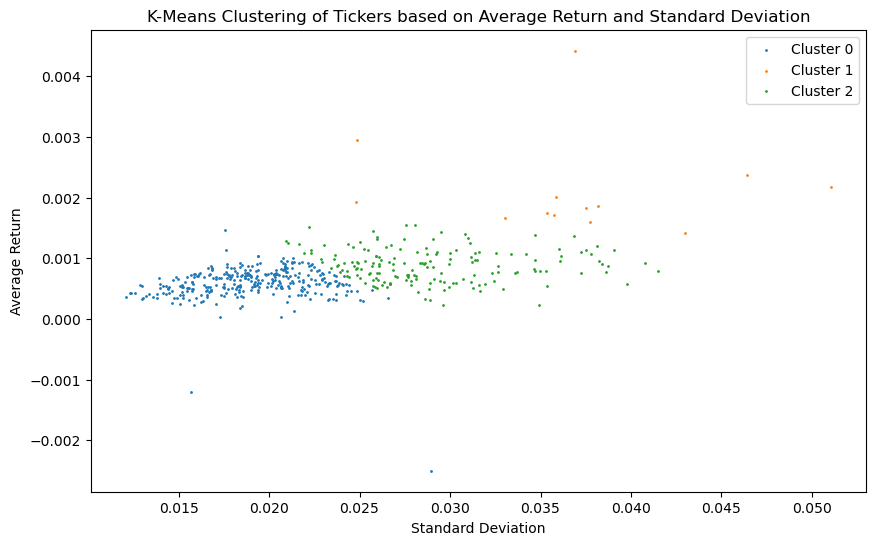

In [116]:

# Assuming you have a DataFrame 'df' with 'Date', 'Ticker', and 'F_1_d_returns' columns
# Group by Ticker and calculate average return and standard deviation
ticker_stats = total_data.groupby('Ticker')['F_1_d_returns'].agg(['mean', 'std'])

# Standardize the data
scaler = StandardScaler()
ticker_stats_scaled = scaler.fit_transform(ticker_stats)

# Number of clusters (you can adjust this)
k = 3

# Perform K-Means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(ticker_stats_scaled)

# Add cluster labels to the original DataFrame
ticker_stats['Cluster'] = clusters

# Count the number of stocks in each cluster
cluster_counts = pd.Series(clusters).value_counts().sort_index()

# Inverse transform scaled mean and std to get the original data
cluster_centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers_original, columns=['mean', 'std'])
cluster_centers_df['Stocks Count'] = cluster_counts.values

# Print the clusters
print("Cluster Centers with Stock Count:")
print(cluster_centers_df)

# Visualize the clusters
# (You may need to adjust this based on your visualization preferences)
plt.figure(figsize=(10, 6))
for cluster in range(k):
    plt.scatter(ticker_stats[ticker_stats['Cluster'] == cluster]['std'],
                ticker_stats[ticker_stats['Cluster'] == cluster]['mean'],
                label=f'Cluster {cluster}', s=1)
plt.title('K-Means Clustering of Tickers based on Average Return and Standard Deviation')
plt.xlabel('Standard Deviation')
plt.ylabel('Average Return')
plt.legend()
plt.show()

###  Use Principal Component Analysis to analyze the past stock returns 


### Create a function to calculate the RSI Indicator and add the RSI to the total_returns dataframe

In [222]:
# Calculate RSI
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi



In [223]:
# Calculate RSI for each ticker separately and add to the DataFrame
total_data['RSI'] = total_data.groupby('Ticker')[['F_1_d_returns']].transform(calculate_rsi)
total_data.head(20)

,,F_1_d_returns,RSI,Position,Realized_Ret
Date,Ticker,,,,
2002-03-01,A,0.059715,NaN,0,0.0
2002-03-04,A,-0.001716,NaN,0,-0.0
2002-03-05,A,-0.013754,NaN,0,-0.0
2002-03-06,A,0.011040,NaN,0,0.0
2002-03-07,A,0.037069,NaN,0,0.0
2002-03-08,A,0.003325,NaN,0,0.0
2002-03-11,A,-0.005523,NaN,0,-0.0
2002-03-12,A,-0.008887,NaN,0,-0.0
2002-03-13,A,-0.000841,NaN,0,-0.0


In [224]:
# Calculate RSI for each ticker separately and add to the DataFrame
total_data['RSI'] = total_data.groupby('Ticker')[['F_1_d_returns']].transform(calculate_rsi)
total_data['RSI'] = total_data['RSI'].shift(1)
total_data.dropna(inplace=True)
total_data.head(5)


,,F_1_d_returns,RSI,Position,Realized_Ret
Date,Ticker,,,,
2002-03-21,A,-0.026897,46.235289,0,-0.0
2002-03-22,A,-0.028513,40.918395,0,-0.0
2002-03-25,A,0.003893,46.787234,0,0.0
2002-03-26,A,-0.008055,52.017175,0,-0.0
2002-03-27,A,0.051429,47.751220,0,0.0


###  Build a trading strategy using RSI

In [225]:
# Define trading strategy based on RSI
def trading_strategy(rsi):
    if rsi < 30:
        return 1  # Go long
    elif rsi > 70:
        return -1  # Go short
    else:
        return 0

# Apply trading strategy to each RSI value
total_data['Position'] = total_data['RSI'].transform(trading_strategy)
# Create Returns for each Trade
total_data['Realized_Ret'] = total_data['F_1_d_returns'] *  total_data['Position'] 

In [226]:
# Compute the daily mean of all stocks. This will be our equal weighted benchmark
df_daily_mean  = pd.DataFrame(total_data.loc[:,'Realized_Ret'].groupby(level='Date').mean())

# Convert daily returns to cumulative return
df_cum_returns = pd.DataFrame((df_daily_mean[['Realized_Ret']]+1).cumprod())

# Calculate the number of years in the dataset
years = len(df_daily_mean) / 252  # Assuming 252 trading days in a year

# Compute the Compound Annual Growth Rate (CAGR)
cagr = round((df_cum_returns['Realized_Ret'].iloc[-1]**(1/years)-1)*100,2)

print(f'The CAGR is: {cagr}%')

# Compute the Sharpe Ratio by annualizing the daily mean and the daily std
df_daily_mean_mean  = df_daily_mean[['Realized_Ret']].describe().iloc[1,:] * 252
df_daily_mean_std   = df_daily_mean[['Realized_Ret']].describe().iloc[2,:] * pow(252,1/2)

sharpe  = df_daily_mean_mean/df_daily_mean_std

print(f'Sharpe Ratio of Strategy: {round(sharpe.iloc[0],2)}')

The CAGR is: -0.01%
Sharpe Ratio of Strategy: -0.06


In [228]:
# Apply trading strategy to each RSI value
import numpy as np
total_data['True_Position'] = np.where(total_data['F_1_d_returns']>0,1,0)

In [233]:
from sklearn.metrics import classification_report

In [235]:
# Define actual and predicted signals (for demonstration purposes)
actual_signals = total_data['True_Position'].tolist()
predicted_signals = total_data['Position'].tolist()

# Compute confusion matrix
cm = confusion_matrix(actual_signals, predicted_signals)

print(classification_report(actual_signals, predicted_signals))

C:\Users\cramk\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cramk\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.48      1.00      0.65   1181283
           1       0.50      0.00      0.00   1260456

    accuracy                           0.48   2441739
   macro avg       0.33      0.33      0.22   2441739
weighted avg       0.49      0.48      0.32   2441739



C:\Users\cramk\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
